# Library and Configuration

In [1810]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
import lmfit
import seaborn as sns
from lmfit.models import GaussianModel
try:
    from Detect_peaks import detect_peaks
except Exception as ep:
    print (ep)
    def detect_peaks(y,mph,mpd=10):
        from peakutils import indexes
        return indexes(y, thres=mph, min_dist=mpd) 
from glob import glob1
import os
import pandas as pd
from Binning_scipy import bin_edge2_bin_center,bin_data_given_bin_center
from theoretical_ion_spacings import theoretical_ion_spacing_um

def Gaussian_fit(x,y,yerr=None,guess_params=None):
    mod = GaussianModel()
    if guess_params is None:
        params = mod.guess(y,x=x)
    else:
        params = mod.make_params(amplitude = guess_params[0], center = guess_params[1], gamma = guess_params[2])
    if yerr is None:
        result = mod.fit(y,params,x=x, nan_policy='omit')
    else:
        result = mod.fit(y,params,x=x,weights=yerr, nan_policy='omit')
    return result, mod

def binomial_mean_err(success_event, num_trials, confidence_interval=0.6827):
    try:
        if success_event <1:
            mean_val = success_event
        else:
            mean_val = success_event/num_trials
    except:
        if success_event[0] <1:
            mean_val = success_event
        else:
            mean_val = success_event/num_trials
    alpha = 1- confidence_interval
    err = (1-alpha/2)*np.sqrt((mean_val*(1-mean_val))/num_trials)
    return mean_val, err
    
def fasterloadtxt(filename,flatten=False,skiprows=None, sep=' '):
    '''
    using pandas to speed up file reading
    '''
    df = pd.read_csv(filename,sep=sep, skiprows=skiprows, header=None)
    if flatten:
        return df.values.flatten()
    else:
        return df.values

No module named 'Detect_peaks'


In [1811]:
color_lst = sns.color_palette("Paired")
color_lst1 = sns.color_palette("rocket_r",  n_colors=8, as_cmap=False)
color_lst2 = sns.color_palette("Set2")

In [1812]:
import matplotlib
textsize = 20
matplotlib.rcParams.update({'font.size': textsize})
matplotlib.rcParams['lines.linewidth'] = 3
matplotlib.rcParams['font.family']='arial'
params = {'legend.edgecolor': '0',
          'lines.markersize' : 6,
          'legend.borderaxespad': 1.5,
          'legend.fancybox': False,
          'legend.fontsize': textsize*0.9,
          'legend.framealpha': 0.5,
          'legend.labelspacing': 0.3,
          'legend.markerscale': 1.0,
          'figure.figsize': (10, 8),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'axes.linewidth': 3,
         'axes.xmargin': 0.03,
         'axes.ymargin': 0.03,
         'xtick.direction': 'in',
         'xtick.labelsize': textsize,
         'xtick.major.pad': 10,
         'xtick.major.size': 10,
         'xtick.major.width': 3,
         'xtick.minor.pad': 10,
         'xtick.minor.size': 5,
         'xtick.minor.visible': True,
         'xtick.minor.width': 2,
         'xtick.top': True,
         'ytick.direction': 'in',
         'ytick.labelsize': textsize,
         'ytick.major.pad': 10,
         'ytick.major.size': 10,
         'ytick.major.width': 3,
         'ytick.minor.pad': 10,
         'ytick.minor.size': 5,
         'ytick.minor.visible': True,
         'ytick.minor.width': 2,
         'ytick.right': True,}
plt.rcParams.update(params)


# Theoretical spacing

In [1813]:
default_ion_position = theoretical_ion_spacing_um(numions=2,endcap_voltages=[420,420])
print ('Ion position at:',default_ion_position)
print (np.diff(default_ion_position))

Ion position at: [-3.97296246  3.97296246]
[7.94592491]


## Analysis strategy

1. AOD data on Thursday: Verify AOD freq -> um separation in a 3-ion string

2. AOD data on Thursday: Convert Population to displacement as a function of time/ waiting time. 152959 –same. Line trigger not used!!!
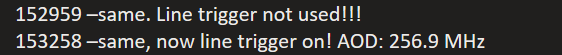
3. Heating Rates data on Friday. Sent those to Marco to analyze. Send him Carrier Rabi flops at 0 waiting time, BSB flops at 0, 5, 10, 20 ms waiting time.
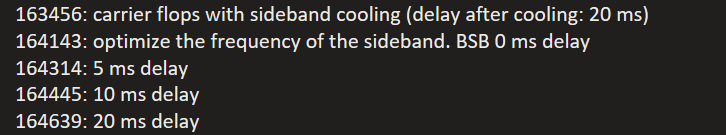

4. Convert population into displacement to extract transport profile as a function of time. files: 190053, 184357, 183833
5. Plot the AOD displacement as a function of delay time.
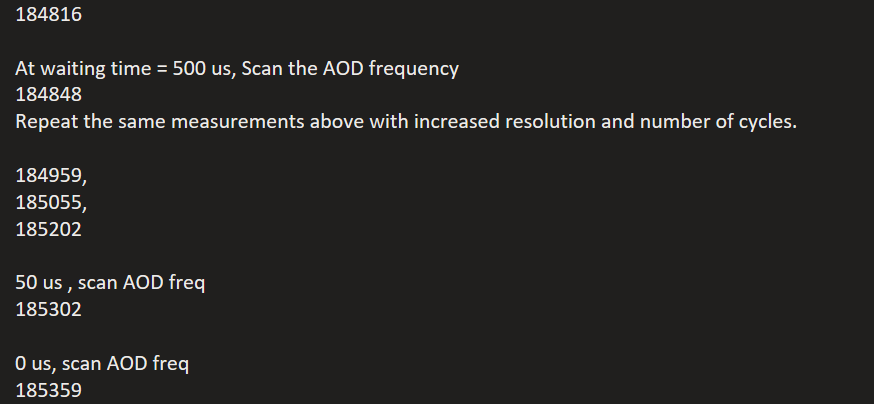

## Optimal data loading

In [1793]:
directory = r'Z:\qfc\measurements\trics_data'
saved_directory1 = r'Z:\qfc\users\Zak\2023-02-09_data_analysis'
saved_directory2 = r'Z:\qfc\users\Zak\2023-02-10_data_analysis'
subfolders = ['2023-02-09','2023-02-10']
aod_file = ['150947','175306','180810','185359','185302','185202','185055','184959','184848','185541']
waiting_time_scan = ['152959','153258','183833','184357','190053']

def readdata(filename, camera=False):
    if camera:
        data = fasterloadtxt(os.path.join(filename,'camera_all.txt'),skiprows=1,sep='\t')
        xvariable = fasterloadtxt(os.path.join(filename,'Camera1_1.txt'),skiprows=1,sep='\t')
        num_trial = fasterloadtxt(os.path.join(filename,'camera_ion1.txt'),skiprows=1,sep='\t')[:,3:].shape[-1]
        data_num = data[:,0]
        prev = data_num[-1]
        valid = np.ones(len(data_num),dtype='bool')
        for j in range(len(data_num)-2,0,-1):
            if data_num[j] == prev:
                valid[j] = False
            prev = data_num[j]
        output = [xvariable[valid],data[valid], num_trial]
    else:
        output = fasterloadtxt(os.path.join(filename,'PMT1_2.txt'),skiprows=1,sep='\t')
        valid = np.ones(len(output[:,0]),dtype='bool')
        for j in range(len(output[:,0])):
            if str(output[:,0][j])[0] == "#":
                valid[j]= False
            

        output = output[valid]
    return output
        

## AOD data -- conversion process
### From a 3-ion string, we get 0.6582 MHz/um

In [1794]:
filename = os.path.join(directory+'\\%s'%subfolders[0],aod_file[0])
data = readdata(filename,camera=True)
xdata = data[0][:,2]
ydata = data[1]
num_trial = data[2]
ion_1, dion_1 = binomial_mean_err(ydata[:,1],num_trial)
ion_2, dion_2 = binomial_mean_err(ydata[:,2],num_trial)
ion_3, dion_3 = binomial_mean_err(ydata[:,3],num_trial)

### fits

result1, mod = Gaussian_fit(xdata,ion_1)#,yerr=dion_1)
ion1_pos = result1.params['center']

result2, mod = Gaussian_fit(xdata,ion_2,yerr=10*ion_2)
ion2_pos = result2.params['center']

### Conversion

sep_MHz = abs(ion2_pos.value- ion1_pos.value)
dsep_MHz = sep_MHz *np.sqrt((ion2_pos.stderr/ion2_pos.value)**2+(ion1_pos.stderr/ion1_pos.value)**2)
sep_um = np.diff(default_ion_position)[0]

ratio_MHz_per_um= sep_MHz/sep_um
dratio_MHz_per_um = ratio_MHz_per_um*dsep_MHz/sep_MHz

print ('AODMHz_to_um is {:.4f} ({:.4f}) MHz/um'.format(ratio_MHz_per_um,dratio_MHz_per_um))

convert_aod_freq_to_sepum = lambda x, conversion_factor: (x-np.median(x))*conversion_factor

AODMHz_to_um is 0.6604 (0.0001) MHz/um


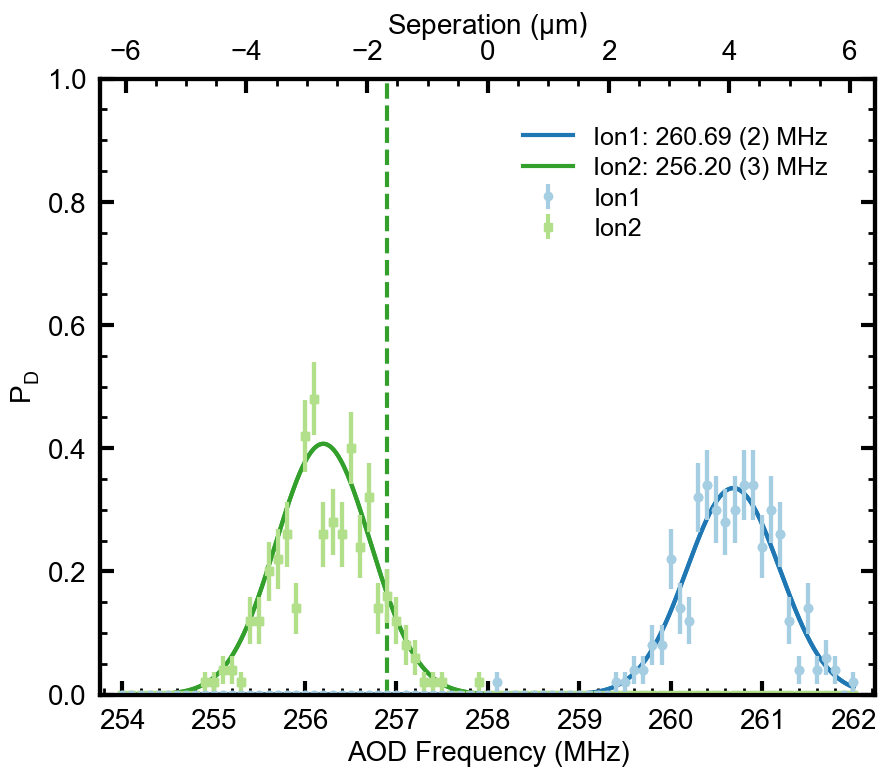

In [685]:
f = plt.figure()
ax = f.add_subplot(111)
ax1 = ax.twiny()
ax.set_xlabel('AOD Frequency (MHz)')
ax.set_ylabel(r'$\mathregular{P_D}$')
ax.set_ylim(0,1)
dummyx = np.linspace(min(xdata),max(xdata),1000)
ax.errorbar(xdata,ion_1,yerr=dion_1,fmt='o',zorder=2,color=color_lst[0],label='Ion1')

ax.plot(dummyx, mod.eval(result1.params,x=dummyx),zorder=0,color=color_lst[1],label='Ion1: %.2f (%.0f) MHz'%(result1.params['center'].value,
                                                                                                      result1.params['center'].stderr*1e2))
ax.errorbar(xdata,ion_2,yerr=dion_2,fmt='s',zorder=1,color=color_lst[2],label='Ion2')

ax.plot(dummyx, mod.eval(result2.params,x=dummyx),zorder=0,color=color_lst[3],label='Ion2: %.2f (%.0f) MHz'%(result2.params['center'].value,
                                                                                                      result2.params['center'].stderr*1e2))
# ax.errorbar(xdata,ion_3,yerr=dion_3,fmt='^',zorder=0,color=color_lst[5],label='Ion3')
ax.legend(loc='best',frameon=False)

ax1.set_xlabel(r'Seperation ($\mathregular{\mu m})$')

ax1.errorbar(convert_aod_freq_to_sepum(xdata,1/ratio_MHz_per_um),ion_1,yerr=dion_1,fmt='o',zorder=2,color=color_lst[0],label='Ion1')

ax1.plot(convert_aod_freq_to_sepum(dummyx,1/ratio_MHz_per_um), mod.eval(result1.params,x=dummyx),zorder=0,color=color_lst[1],label='Ion1: %.2f (%.0f) MHz'%(result1.params['center'].value,
                                                                                                      result1.params['center'].stderr*1e2))
ax1.errorbar(convert_aod_freq_to_sepum(xdata,1/ratio_MHz_per_um),ion_2,yerr=dion_2,fmt='s',zorder=1,color=color_lst[2],label='Ion2')

ax1.plot(convert_aod_freq_to_sepum(dummyx,1/ratio_MHz_per_um), mod.eval(result2.params,x=dummyx),zorder=0,color=color_lst[3],label='Ion2: %.2f (%.0f) MHz'%(result2.params['center'].value,
                                                                                                      result2.params['center'].stderr*1e2))

ax.axvline(x=256.9,color=color_lst[3],ls='--')

f.savefig(os.path.join(saved_directory1,'%s_aod_3ion.png'%aod_file[0]),dpi=100,bbox_inches='tight')

## Ion Position Stability

In [677]:
filename = os.path.join(directory+'\\%s'%subfolders[0],waiting_time_scan[1])
data = readdata(filename,camera=True)
xdata = data[0][:,2]
ydata = data[1]
num_trial = data[2]
ion_1, dion_1 = binomial_mean_err(ydata[:,1],num_trial)
ion_2, dion_2 = binomial_mean_err(ydata[:,2],num_trial)
ion_3, dion_3 = binomial_mean_err(ydata[:,3],num_trial)
aod_freq = 256.900000
waiting_time_scan[1]

'153258'

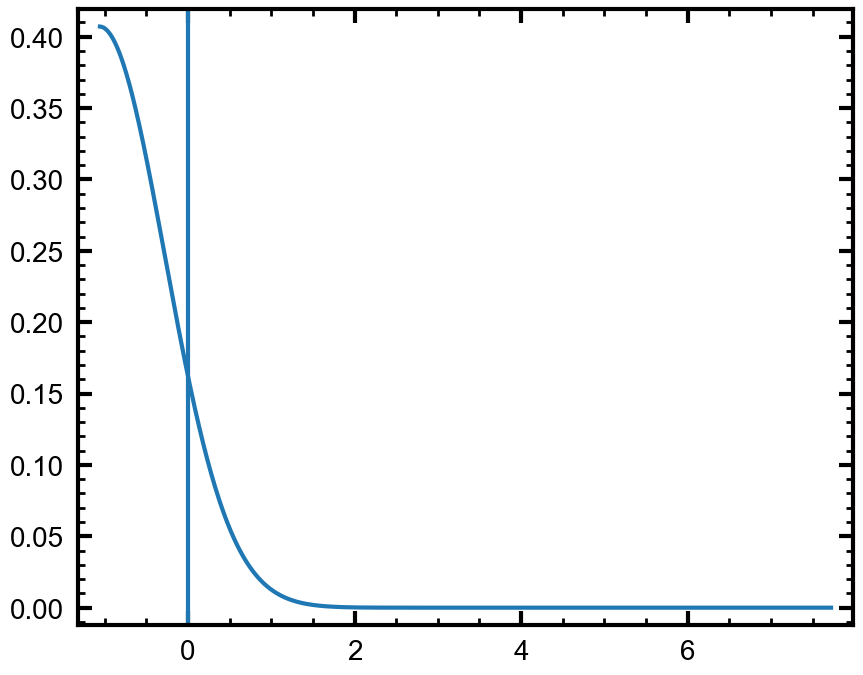

In [678]:
valid = np.argmax(mod.eval(result2.params,x=dummyx))
x0 = (aod_freq-np.median(dummyx))/ratio_MHz_per_um
maximum_value = mod.eval(result2.params,x=dummyx)[valid:][0]
plt.plot(convert_aod_freq_to_sepum(dummyx,1/ratio_MHz_per_um)[valid:]-x0,1*mod.eval(result2.params,x=dummyx)[valid:] )
plt.axvline(x = x0*0)
from scipy.interpolate import interp1d

interpolate_function = interp1d(x= 1*mod.eval(result2.params,x=dummyx)[valid:], y = convert_aod_freq_to_sepum(dummyx,1/ratio_MHz_per_um)[valid:]-x0)


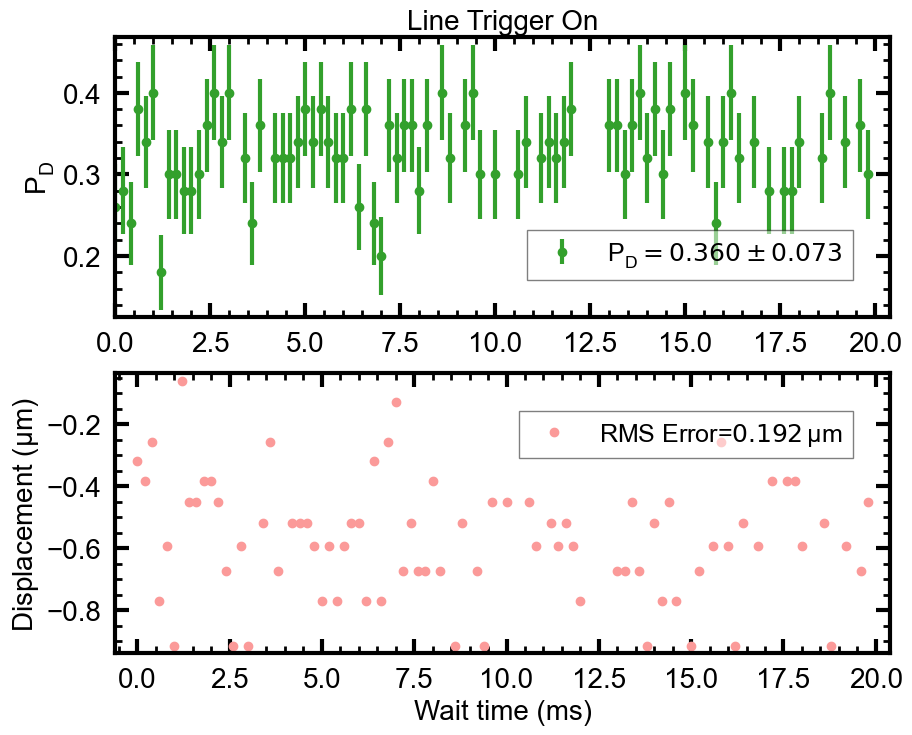

In [680]:
f = plt.figure()
ax = f.add_subplot(211)
ax1 =  f.add_subplot(212)
valid = ion_2 < maximum_value
ax1.errorbar(xdata[valid]/1e3, interpolate_function(ion_2[valid]),color=color_lst[4],fmt='o',alpha=1,label=r'RMS Error=$%.3f\,\mathregular{\mu m}$'%(interpolate_function(ion_2[valid]).std()))
ax.errorbar(xdata[valid]/1e3,ion_2[valid],yerr=dion_2[valid],fmt='o',color=color_lst[3],label=r'$\mathregular{P_D}=%.3f\pm%.3f$'%(ion_2.mean(),ion_2.std()))
# ax.set_ylim(0,1)
ax.set_xlim(left=0)
ax1.set_xlabel('Wait time (ms)')
ax.set_ylabel(r'$\mathregular{P_D}$')
ax.legend(loc='best')
ax1.legend(loc='best')
ax1.set_ylabel(r'Displacement ($\mathregular{\mu m}$)')
ax.set_title('Line Trigger On')
f.savefig(os.path.join(saved_directory1,'%s_wait_time_scan_ion2_linetrigger_on.png'%waiting_time_scan[1]),dpi=100,bbox_inches='tight')

# AOD scan during movements

In [551]:
waiting_time = []
xdata = []
ydata = []
dydata = []

aod_file = ['150947','175306','180810','185359','185302','185202','185055','184959','184848','185541']

for j in range(1,len(aod_file),1):
    filename = os.path.join(directory+'\\%s'%subfolders[1],aod_file[j])
    data = readdata(filename,camera=False)
    _xdata = data[:,2]
    _ydata = data[:,4]
    num_trial = data[10][6:].shape[0]
    ion_1, dion_1 = binomial_mean_err(_ydata,num_trial)
    xdata.append(data[:,2])
    ydata.append(ion_1)
    dydata.append(dion_1)
    string = fasterloadtxt(filename+'\\ExperimentSettings.txt',flatten=True)[20]
    start = string.find('waiting')+8
    end = string.find('TRANSITION')-1
    waiting_time.append(float(string[start:end]))
# ion_2, dion_2 = binomial_mean_err(ydata[:,2],num_trial)
# ion_3, dion_3 = binomial_mean_err(ydata[:,3],num_trial)
aod_file[2]

'180810'

In [557]:
waiting_time

[1000.0, 1000.0, 0.0, 50.0, 500.0, 150.0, 500.0, 500.0, 150.0]

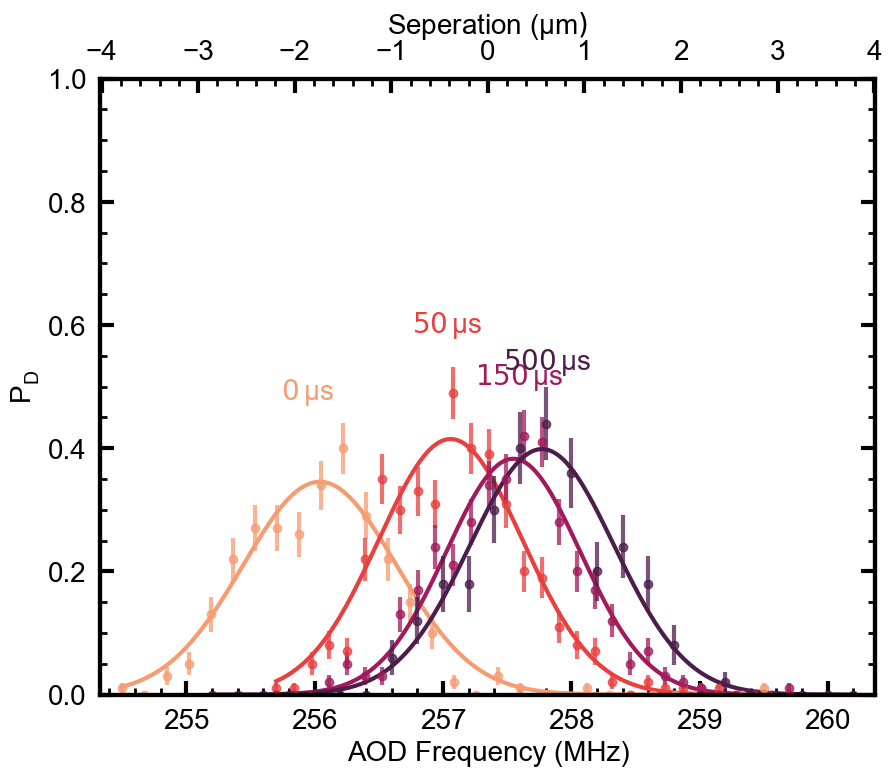

In [611]:
plot_lst = [2,3,5,7]
cnt = 0
f = plt.figure()
ax  =f.add_subplot(111)
ax1 = ax.twiny()
for j in plot_lst:
    ax.errorbar(xdata[j],ydata[j],yerr=dydata[j],color=color_lst1[cnt],fmt='o',alpha=0.75,label='$%.0f\,\mathregular{\mu s}$'%(waiting_time[j]))
    result, mod = Gaussian_fit(xdata[j],ydata[j],yerr=dydata[j])
    dummyx = np.linspace(min(xdata[j]),max(xdata[j]),1000)
    ax.plot(dummyx,mod.eval(result.params,x=dummyx),color=color_lst1[cnt])
    ax.text(result.params['center'].value-.3, 1.2*max(ydata[j]),'$%.0f\,\mathregular{\mu s}$'%(waiting_time[j]),color=color_lst1[cnt])
    ax1.errorbar(convert_aod_freq_to_sepum(xdata[j],1/ratio_MHz_per_um),ydata[j],yerr=dydata[j],fmt='o',zorder=2,color=color_lst1[-1],alpha=0)
    cnt += 1
    
# ax.legend(loc='best')

ax.set_xlabel('AOD Frequency (MHz)')
ax.set_ylabel(r'$\mathregular{P_D}$')
ax.set_ylim(0,1)
ax1.set_ylim(0,1)
ax1.set_xlabel(r'Seperation ($\mathregular{\mu m})$')
f.savefig(os.path.join(saved_directory2,'%s_aod_1ion_waiting_time.png'%aod_file[2]),dpi=100,bbox_inches='tight')

## Waiting time scan

In [651]:
xdata = []
ydata = []
dydata = []
aod_freq = []

waiting_time_scan = ['152959','153258','183833','184357','190053']

for j in range(2,len(waiting_time_scan),1):
    filename = os.path.join(directory+'\\%s'%subfolders[1],waiting_time_scan[j])
    data = readdata(filename,camera=False)
    _xdata = data[:,2]
    _ydata = data[:,4]
    num_trial = data[10][6:].shape[0]
    ion_1, dion_1 = binomial_mean_err(_ydata,num_trial)
    xdata.append(data[:,2])
    ydata.append(ion_1)
    dydata.append(dion_1)
    string = fasterloadtxt(filename+'\\ExperimentSettings.txt',flatten=True)[20]
    start = string.find('AOD;FREQ,')+9
    aod_freq.append(float(string[start:start+10]))


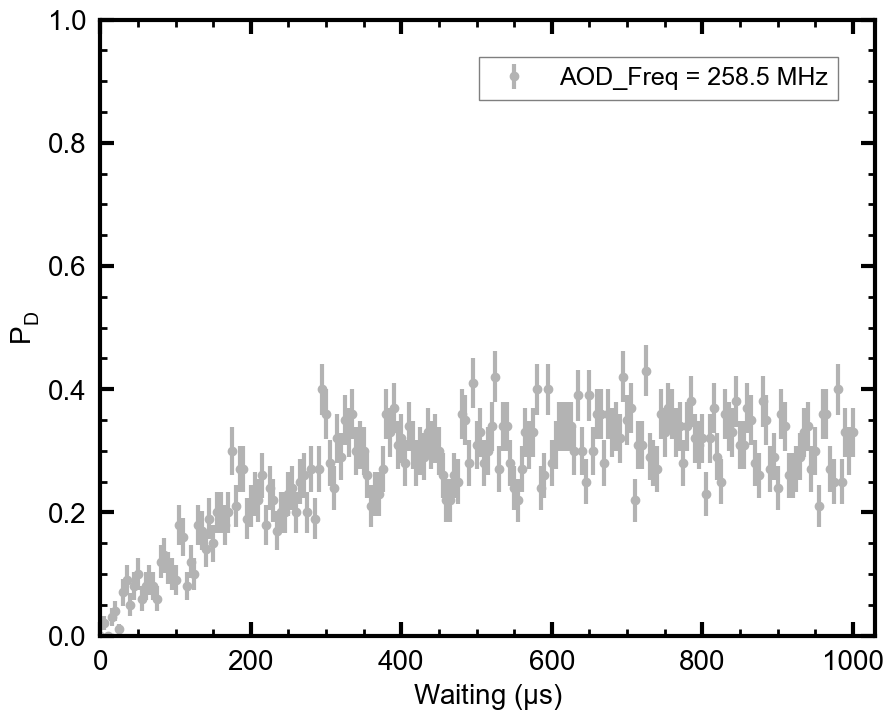

In [661]:
f = plt.figure()
ax = f.add_subplot(111)
j = -1
ax.errorbar(xdata[j],ydata[j],yerr=dydata[j],fmt='o',color=color_lst2[j],label='AOD_Freq = %.1f MHz'%aod_freq[j])
# ax.errorbar(xdata[1],ydata[1],yerr=dydata[1],fmt='o',color=color_lst2[1])
# ax.errorbar(xdata[2],ydata[2],yerr=dydata[2],fmt='o',color=color_lst2[2])
ax.set_xlabel(r'Waiting ($\mathregular{\mu s}$)')
ax.set_ylabel(r'$\mathregular{P_D}$')
ax.legend(loc='best')
ax.set_ylim(0,1)
ax.set_xlim(left=0)
f.savefig(os.path.join(saved_directory2,'%s_1ion_waiting_time.png'%waiting_time_scan[j+2]),dpi=100,bbox_inches='tight')

## Oscilloscope profile

In [1225]:
directory = r'Z:\qfc\measurements\general\2023\Oscilloscope_Logging\OutputWaveform_ShuttlingBoard'
filename = ['11022023_5ms_Pulse_1Vpp_17ns_rise_2_100kHz_filter.csv','11022023_5ms_Pulse_1Vpp_25us_rise_2_100kHz_filter.csv']

In [1227]:
trace = fasterloadtxt(os.path.join(directory,filename[0]),sep=',',skiprows=2,flatten=False)
trace1 = fasterloadtxt(os.path.join(directory,filename[1]),sep=',',skiprows=2,flatten=False)

Text(0.5, 0, 'Time ($\\mathregular{\\mu s}$)')

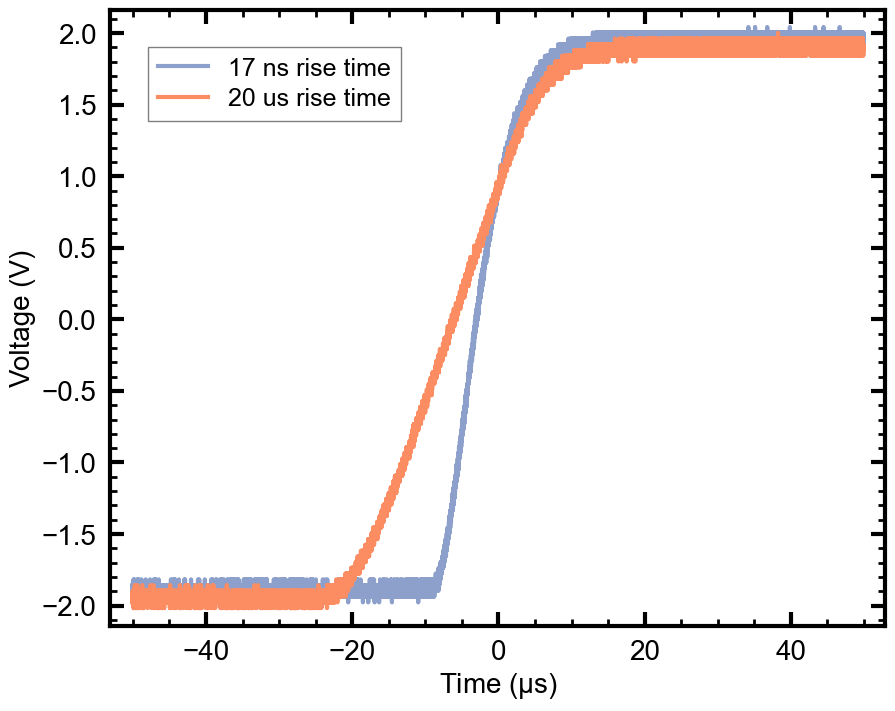

In [1228]:
f = plt.figure()
ax = f.add_subplot(111)
ax.plot(trace[:,0]*1e6,trace[:,1],color=color_lst2[2],label='17 ns rise time')
ax.plot(trace1[:,0]*1e6,trace1[:,1],color=color_lst2[1],label='20 us rise time')
ax.legend(loc='best')
ax.set_ylabel('Voltage (V)')
ax.set_xlabel(r'Time ($\mathregular{\mu s}$)')
# f.savefig(os.path.join(directory,filename[0][:-4]+'_summary.png'),dpi=100,bbox_inches='tight',facecolor='white')

## BSB flop after shuttling

In [777]:
bsb_filenames = ['165924','172700','164143','161541']

xdata = []
ydata = []
dydata = []
for j in range(len(bsb_filenames)):
    filename = os.path.join(directory+'\\%s'%subfolders[1],bsb_filenames[j])
    data = readdata(filename,camera=False)
    _xdata = data[:,2]
    _ydata = data[:,4]
    num_trial = data[10][6:].shape[0]
    ion_1, dion_1 = binomial_mean_err(_ydata,num_trial)
    xdata.append(_xdata)
    ydata.append(ion_1)
    dydata.append(dion_1)

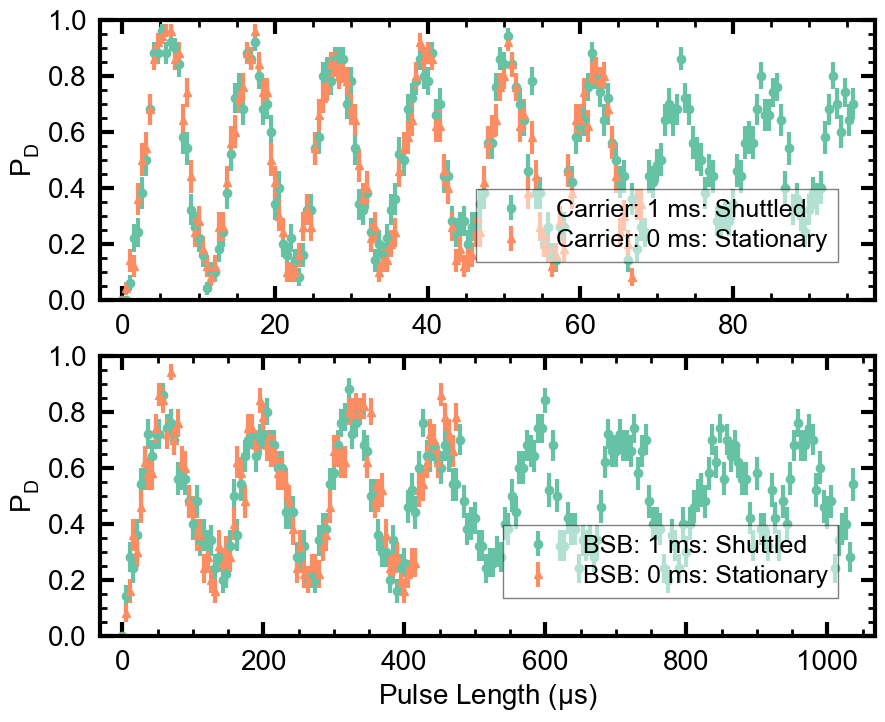

In [788]:
f = plt.figure()
ax0  =f.add_subplot(211)
j = 0
ax0.errorbar(xdata[j],ydata[j],yerr=dydata[j],fmt='o',color=color_lst2[0],alpha=1,
           label = 'Carrier: 1 ms: Shuttled')

j = 3
ax0.errorbar(xdata[j],ydata[j],yerr=dydata[j],fmt='^',color=color_lst2[1],alpha=1,
           label = 'Carrier: 0 ms: Stationary')

ax0.set_ylim(0,1)
ax  =f.add_subplot(212)
j = 1
ax.errorbar(xdata[j],ydata[j],yerr=dydata[j],fmt='o',color=color_lst2[0],alpha=1,
           label = 'BSB: 1 ms: Shuttled')

j = 2
ax.errorbar(xdata[j],ydata[j],yerr=dydata[j],fmt='^',color=color_lst2[1],alpha=1,
           label = 'BSB: 0 ms: Stationary')

ax.set_xlabel(r'Pulse Length ($\mathregular{\mu s}$)')
ax0.set_ylabel(r'$\mathregular{P_D}$')
ax.set_ylabel(r'$\mathregular{P_D}$')
ax0.legend(loc='lower right')
ax.legend(loc='lower right')
ax.set_ylim(0,1)
f.savefig(os.path.join(saved_directory2,'%s_1ion_waiting_time_bsb_carrier_shuttling.png'%bsb_filenames[1]),dpi=100,bbox_inches='tight',facecolor='white')

## BSB stationary and increasing wait time

In [839]:
bsb_filenames = ['164143','164314','164445','164639']
# bsb_filenames = ['163456','161541']

xdata = []
ydata = []
dydata = []
for j in range(len(bsb_filenames)):
    filename = os.path.join(directory+'\\%s'%subfolders[1],bsb_filenames[j])
    data = readdata(filename,camera=False)
    _xdata = data[:,2]
    _ydata = data[:,4]
    num_trial = data[10][6:].shape[0]
    ion_1, dion_1 = binomial_mean_err(_ydata,num_trial)
    xdata.append(_xdata)
    ydata.append(ion_1)
    dydata.append(dion_1)

Text(0, 0.5, '$\\mathregular{P_D}$')

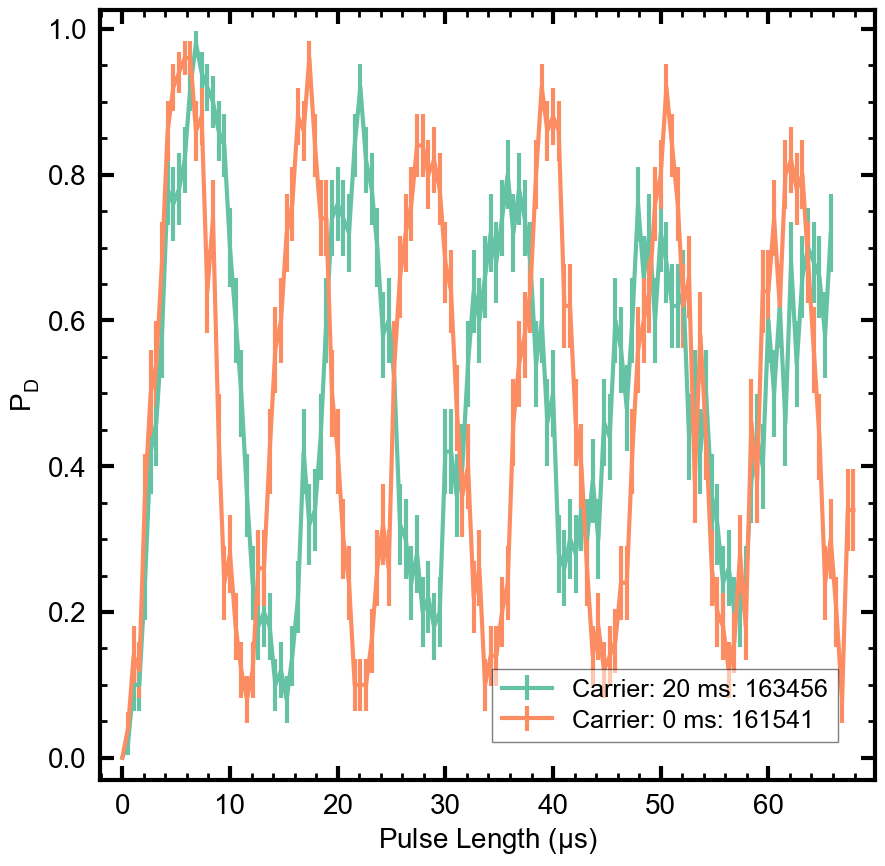

In [837]:
f = plt.figure(figsize=(10,10))
ax0  =f.add_subplot(111)
j = 0
ax0.errorbar(xdata[j],ydata[j],yerr=dydata[j],fmt='-',color=color_lst2[j],alpha=1,
           label = 'Carrier: 20 ms: %s'%(bsb_filenames[j]))
j = 1
ax0.errorbar(xdata[j],ydata[j],yerr=dydata[j],fmt='-',color=color_lst2[j],alpha=1,
           label = 'Carrier: 0 ms: %s'%(bsb_filenames[j]))
ax0.legend(loc='best')
ax0.set_xlabel(r'Pulse Length ($\mathregular{\mu s}$)')
ax0.set_ylabel(r'$\mathregular{P_D}$')

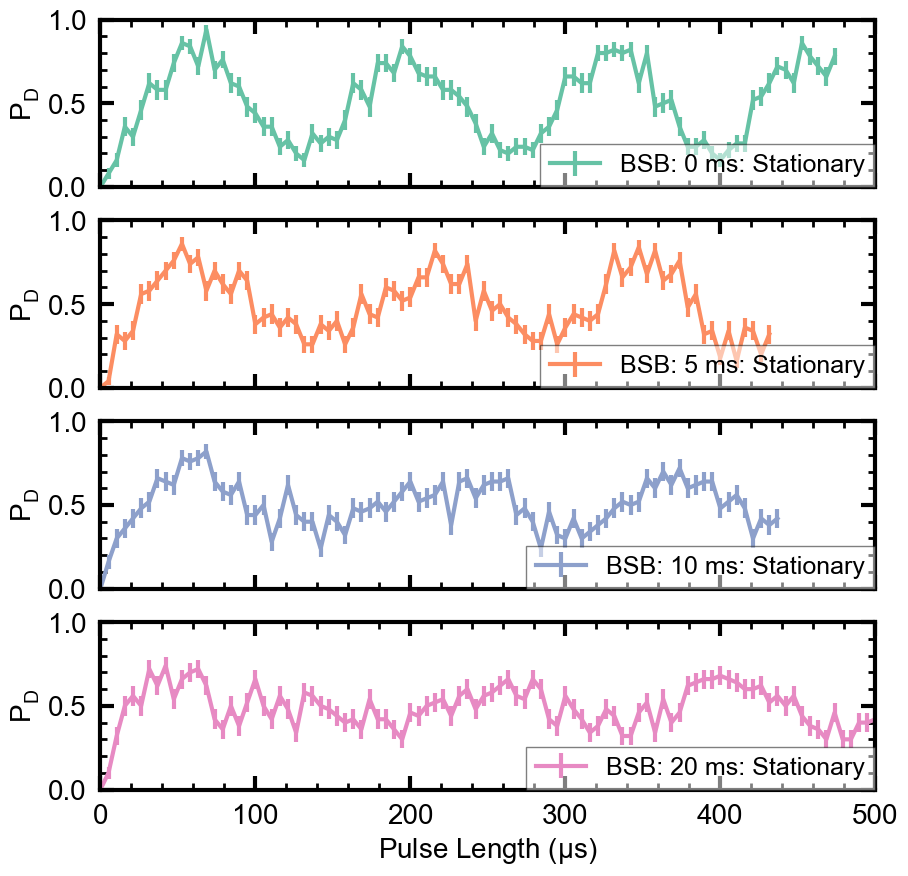

In [840]:
f = plt.figure(figsize=(10,10))
ax0  =f.add_subplot(411)
j = 0
ax0.errorbar(xdata[j],ydata[j],yerr=dydata[j],fmt='-',color=color_lst2[j],alpha=1,
           label = 'BSB: 0 ms: Stationary')

ax0.set_ylim(0,1)
ax0.set_xticklabels([])

ax1  =f.add_subplot(412)
j = 1
ax1.errorbar(xdata[j],ydata[j],yerr=dydata[j],fmt='-',color=color_lst2[j],alpha=1,
           label = 'BSB: 5 ms: Stationary')

ax1.set_ylim(0,1)
ax1.set_xticklabels([])

ax2  =f.add_subplot(413)
j = 2
ax2.errorbar(xdata[j],ydata[j],yerr=dydata[j],fmt='-',color=color_lst2[j],alpha=1,
           label = 'BSB: 10 ms: Stationary')

ax2.set_ylim(0,1)
ax2.set_xticklabels([])
ax  =f.add_subplot(414)
j = 3
ax.errorbar(xdata[j],ydata[j],yerr=dydata[j],fmt='-',color=color_lst2[j],alpha=1,
           label = 'BSB: 20 ms: Stationary')

ax.set_ylim(0,1)


ax.set_xlabel(r'Pulse Length ($\mathregular{\mu s}$)')
ax0.set_ylabel(r'$\mathregular{P_D}$')
ax1.set_ylabel(r'$\mathregular{P_D}$')
ax2.set_ylabel(r'$\mathregular{P_D}$')
ax.set_ylabel(r'$\mathregular{P_D}$')
ax0.set_xlim(0,500)
ax1.set_xlim(0,500)
ax2.set_xlim(0,500)
ax.set_xlim(0,500)
ax0.legend(loc='lower right',borderaxespad=0)
ax1.legend(loc='lower right',borderaxespad=0)
ax2.legend(loc='lower right',borderaxespad=0)
ax.legend(loc='lower right',borderaxespad=0)
# f.savefig(os.path.join(saved_directory2,'%s_1ion_waiting_time_bsb_stationary.png'%bsb_filenames[0]),dpi=300,bbox_inches='tight',facecolor='white')

# Data taken on the 16th of February 2023
1. AOD scan of a two ion string
2. Temperature of a two-ion string, measurement via Rabi flops after shuttling.
3. Axial stability
4. Motional coherence

## AOD scan

In [1817]:
directory = r'Z:\qfc\measurements\trics_data'
saved_directory1 = r'Z:\qfc\users\Zak\2023-02-16_data_analysis'
subfolders = ['2023-02-16']
aod_file = ['111858','112418','113857','113745','113933','114026','114129','114220','114347','114439','114533','142019']
waiting_time_scan = ['113056','113532','142345']

In [1818]:
waiting_time = []
xdata = []
ydata = []
dydata = []
array_range = range(len(aod_file))[:]
for j in array_range:
    filename = os.path.join(directory+'\\%s'%subfolders[0],aod_file[j])
    try:
        data = readdata(filename,camera=False)
    except:
        data = readdata(filename,camera=True)
    _xdata = np.array(data[:,2],dtype='float')
    if j==0:
        _ydata = np.zeros(len(_xdata))
        for k in range(len(_xdata)):
            out = np.histogram(data[k][6:],bins=[0,20,55,120],density=False)[0]
            _ydata[k] = out[1]/sum(out)
    else:
        _ydata = np.zeros(len(_xdata))
        for k in range(len(_xdata)):
            out = np.histogram(data[k][6:],bins=[0,20,70,120],density=False)[0]
            _ydata[k] = out[1]/sum(out)
    num_trial = data[0][6:].shape[0]
    ion_1, dion_1 = binomial_mean_err(_ydata,num_trial)
    
    xdata.append(data[:,2])
    ydata.append(ion_1)
    dydata.append(dion_1)
    string = fasterloadtxt(filename+'\\ExperimentSettings.txt',flatten=True)[20]
    start = string.find('waiting')+8
    end = string.find('TRANSITION')-1
    # print (string[start:end])
    waiting_time.append(float(string[start:end]))
    # plt.plot(_xdata,_ydata,'o-')
    # plt.ylim(bottom=0,top=1)

In [1819]:
def double_gaussian(x,y):
    def half_max_x(x, y):
        half = max(y)/2.0
        signs = np.sign(np.add(y, -half))
        zero_crossings = (signs[0:-2] != signs[1:-1])
        zero_crossings_i = np.where(zero_crossings)[0]
        return [lin_interp(x, y, zero_crossings_i[0], half),
                lin_interp(x, y, zero_crossings_i[1], half)]
    
    mod = GaussianModel(prefix='g1') + GaussianModel(prefix='g2')
    mod.set_param_hint('sep',expr='abs(g1center-g2center)',vary=False)
    peaks = detect_peaks(y,mph=max(y)/1.15,mpd=15)
    peakcen = x[peaks]
    peakamp = y[peaks]
    if len(peaks) <2:
        peakcen = [peakcen[0],peakcen[0]]
    # print (peakcen)
    params = mod.make_params(g1center=peakcen[0], g2center=peakcen[-1], g1amplitude=peakamp[0], g2amplitude=peakamp[1], g1sigma=.25, g2sigma=.25)
    params['g1amplitude'].set(min=0)
    params['g2amplitude'].set(min=0)
    params['g1sigma'].set(min=0,max=0.7)
    params['g2sigma'].set(min=0,max=0.7)
    result = mod.fit(y,params,x=x)
    # print (result.fit_report())
    return result, mod

Separation between 2 ions are 5.262 +- 0.045 MHz
2-ion string at 582 kHz axial, separation is 8.0363597 um
Hence, this gives the conversion factor of 1.527 +- 0.013 um/MHz


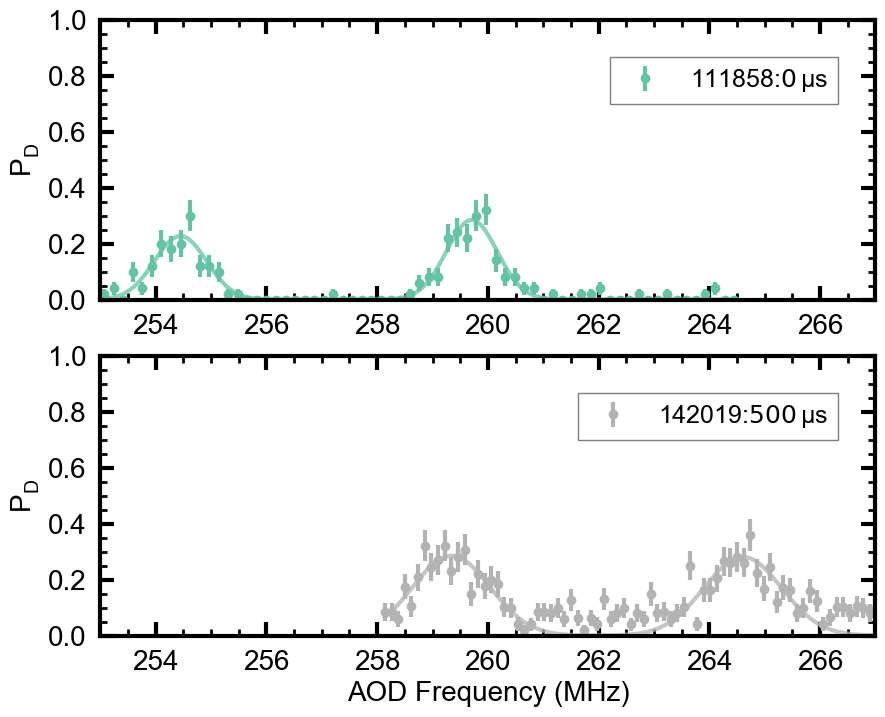

In [1820]:
f = plt.figure(figsize=(10,8))
# f.subplots_adjust(hspace=0.3)
ax = f.add_subplot(211)
ax1 = f.add_subplot(212)
ax1.set_xlabel('AOD Frequency (MHz)')
j = 0
ax.errorbar(xdata[0],ydata[0],yerr=dydata[0],color=color_lst2[0],fmt='o',label=r'%s:$%.0f\,\mathregular{\mu s}$'%(aod_file[j],0))

result1, mod = double_gaussian(xdata[j],ydata[j])
dummyx = np.linspace(min(xdata[j]),max(xdata[j]),1000)
ax.plot(dummyx,mod.eval(result1.params,x=dummyx),color=color_lst2[j],alpha=0.75)

sep = result1.params['sep'].value
dsep = result1.params['sep'].stderr

j = -1
ax1.errorbar(xdata[j],ydata[j],yerr=dydata[j],color=color_lst2[j%8],fmt='o',label=r'%s:$%.0f\,\mathregular{\mu s}$'%(aod_file[j],500))
result1, mod = double_gaussian(xdata[j],ydata[j])
dummyx = np.linspace(min(xdata[j]),max(xdata[j]),1000)
ax1.plot(dummyx,mod.eval(result1.params,x=dummyx),color=color_lst2[j],alpha=0.75)
ax.legend(loc='best')
ax1.legend(loc='best')
ax.set_ylim(0,1)
ax.set_xlim(253,267)
ax.set_ylabel(r'$\mathregular{P_D}$')

ax1.set_ylim(0,1)
ax1.set_xlim(253,267)
ax1.set_ylabel(r'$\mathregular{P_D}$')


print ('Separation between 2 ions are {:.3f} +- {:.3f} MHz'.format(sep,dsep))
print ('2-ion string at 582 kHz axial, separation is 8.0363597 um')
print ('Hence, this gives the conversion factor of {:.3f} +- {:.3f} um/MHz'.format(8.0363597/sep,8.0363597*(dsep/sep)/sep))
# f.savefig(os.path.join(saved_directory1,'aod_scan_with_shuttling_moving1ion2another.png'),dpi=100,bbox_inches='tight',facecolor='white')

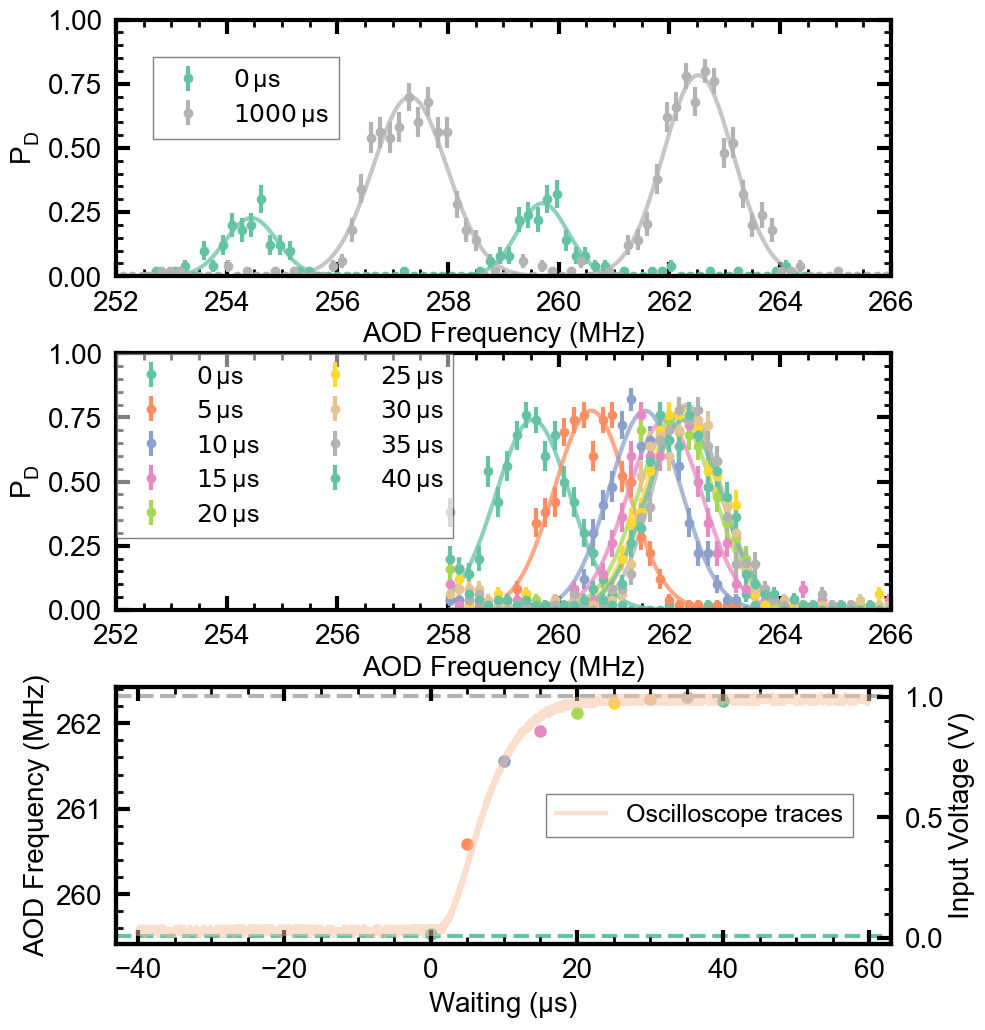

In [1277]:
xcenter = []
dcenter = []
f = plt.figure(figsize=(10,12))
f.subplots_adjust(hspace=0.3)
ax = f.add_subplot(311)
ax.set_xlabel('AOD Frequency (MHz)')
ax.errorbar(xdata[0],ydata[0],yerr=dydata[0],color=color_lst2[0],fmt='o',label=r'$%.0f\,\mathregular{\mu s}$'%(0))
j = 0
result1, mod = double_gaussian(xdata[j],ydata[j])
dummyx = np.linspace(min(xdata[j]),max(xdata[j]),1000)
ax.plot(dummyx,mod.eval(result1.params,x=dummyx),color=color_lst2[j],alpha=0.75)

ax.errorbar(xdata[1],ydata[1],yerr=dydata[1],color=color_lst2[-1],fmt='o',label=r'$%.0f\,\mathregular{\mu s}$'%(waiting_time[1]))
j = 1
result2, mod = double_gaussian(xdata[j],ydata[j])
dummyx = np.linspace(min(xdata[j]),max(xdata[j]),1000)
ax.plot(dummyx,mod.eval(result2.params,x=dummyx),color=color_lst2[-1],alpha=0.75)

ax.set_ylim(0,1)
ax.set_xlim(252,266)

ax1 = f.add_subplot(312)
ax1.set_xlabel('AOD Frequency (MHz)')
for j in range(2,11,1):
    ax1.errorbar(xdata[j],ydata[j],yerr=dydata[j],color=color_lst2[(j-2)%8],fmt='o',label=r'$%.0f\,\mathregular{\mu s}$'%(waiting_time[j]))
    result, mod = Gaussian_fit(xdata[j],ydata[j])
    dummyx = np.linspace(min(xdata[j]),max(xdata[j]),1000)
    xcenter.append(result.params['center'].value)
    dcenter.append(result.params['center'].stderr)
    ax1.plot(dummyx,mod.eval(result.params,x=dummyx),color=color_lst2[(j-2)%8],alpha=0.75)
ax1.set_ylim(0,1)
ax1.legend(loc='best',ncol=2,frameon=True,borderaxespad=0)
ax.legend(loc='best')
ax1.set_xlim(252,266)
ax.set_ylabel(r'$\mathregular{P_D}$')
ax1.set_ylabel(r'$\mathregular{P_D}$')

ax2 = f.add_subplot(313)
ax3 = ax2.twinx()
ax2.set_ylabel('AOD Frequency (MHz)')
ax2.set_xlabel(r'Waiting ($\mathregular{\mu s}$)')
ax2.axhline(y=result1.params['g2center'].value-0.2,color=color_lst2[0],ls='--',zorder=0)
ax2.axhline(y=result2.params['g2center'].value-0.2,color=color_lst2[-1],ls='--',zorder=0)

ax3.plot(trace[:,0]*1e6+10,trace[:,1]/4 +0.5,color=color_lst1[0],label='Oscilloscope traces',alpha=0.5,zorder=0)
ax3.legend(loc='center right')
ax3.set_ylabel('Input Voltage (V)')
for j in range(len(xcenter)):
    ax2.errorbar(waiting_time[2:-1][j],xcenter[j],yerr=dcenter[j],fmt='o',color=color_lst2[j%8],markersize=8,zorder=1)
f.savefig(os.path.join(saved_directory1,'aod_scan_with_shuttling.png'),dpi=100,bbox_inches='tight',facecolor='white')

## waiting time scan

In [1821]:
xdata = []
ydata = []
dydata = []
aod_freq = []

waiting_time_scan = ['113056','113532','142345']

for j in range(len(waiting_time_scan)):
    filename = os.path.join(directory+'\\%s'%subfolders[0],waiting_time_scan[j])
    try:
        data = readdata(filename,camera=False)
    except:
        data = readdata(filename,camera=True)
    _xdata = np.array(data[:,2],dtype='float')
    if j==0:
        # _ydata = np.array(data[:,4],dtype='float')
        _ydata = np.zeros(len(_xdata))
        for k in range(len(_xdata)):
            out = np.histogram(data[k][6:],bins=[0,20,55,120],density=False)[0]
            _ydata[k] = out[1]/sum(out)
    else:
        _ydata = np.zeros(len(_xdata))
        for k in range(len(_xdata)):
            out = np.histogram(data[k][6:],bins=[0,20,70,120],density=False)[0]
            _ydata[k] = out[1]/sum(out)
    num_trial = data[0][6:].shape[0]
    ion_1, dion_1 = binomial_mean_err(_ydata,num_trial)
    xdata.append(_xdata)
    ydata.append(ion_1)
    dydata.append(dion_1)

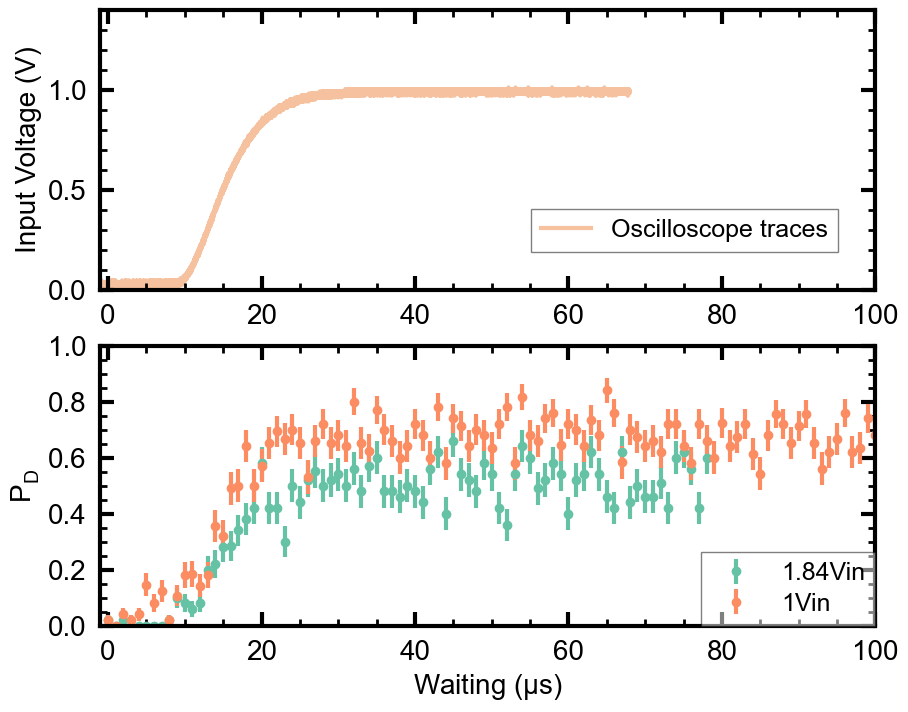

In [1816]:
f = plt.figure()
ax1  =f.add_subplot(211)
ax = f.add_subplot(212)
ax1.plot(trace[:,0]*1e6+18,trace[:,1]/4 +0.5,color=color_lst1[0],label='Oscilloscope traces',alpha=1,zorder=0,ls='-')
# ax.plot(xdata[0],ydata[0],'-')
ax.errorbar(xdata[1],ydata[1],yerr=dydata[1],fmt='o',color=color_lst2[0],label='1.84Vin')
# ax1.errorbar(waiting_time[2:-1],xcenter,yerr=dcenter,fmt='o',color=color_lst2[1])
ax.errorbar(xdata[2],ydata[2],yerr=dydata[2],fmt='o',color=color_lst2[1],label='1Vin')
ax.set_xlabel(r'Waiting ($\mathregular{\mu s}$)')
ax.set_ylabel(r'$\mathregular{P_D}$')
ax.set_xlim(-1,100)
ax1.set_xlim(-1,100)
ax.legend(loc='lower right',borderaxespad=0)
ax.set_ylim(0,1)
ax1.set_ylim(0,1.4)
ax1.legend(loc='lower right')
ax1.set_ylabel('Input Voltage (V)')
f.savefig(os.path.join(saved_directory1,'waiting_scan_with_shuttling.png'),dpi=100,bbox_inches='tight',facecolor='white')
# ax1.set_xlim(-1,80)
# ax1.set_ylabel('AOD Frequency (MHz)')

## Axial after shuttling

In [1438]:
xdata = []
ydata = []
dydata = []
aod_freq = []

freq_scan = ['150112','150409']
# freq_scan = ['145655','145346'] # dither level 8
label=['Shuttled', 'Stationary']

for j in range(len(freq_scan)):
    filename = os.path.join(directory+'\\%s'%subfolders[0],freq_scan[j])
    try:
        data = readdata(filename,camera=False)
    except:
        data = readdata(filename,camera=True)
    _xdata = np.array(data[:,2],dtype='float')
    _ydata = np.array(data[:,4],dtype='float')
    # if j==0:
    #     #_ydata = np.array(data[:,4],dtype='float')
    #     _ydata = np.zeros(len(_xdata))
    #     for k in range(len(_xdata)):
    #         out = np.histogram(data[k][6:],bins=[0,15,53,120],density=False)[0]
    #         _ydata[k] = out[1]/sum(out)
    # else:
    #     _ydata = np.zeros(len(_xdata))
    #     for k in range(len(_xdata)):
    #         out = np.histogram(data[k][6:],bins=[0,30,85,120],density=False)[0]
    #         _ydata[k] = out[1]/sum(out)
    num_trial = data[0][6:].shape[0]
    ion_1, dion_1 = binomial_mean_err(_ydata,num_trial)
    xdata.append(_xdata)
    ydata.append(ion_1)
    dydata.append(dion_1)

Text(0, 0.5, '$\\mathregular{P_D}$')

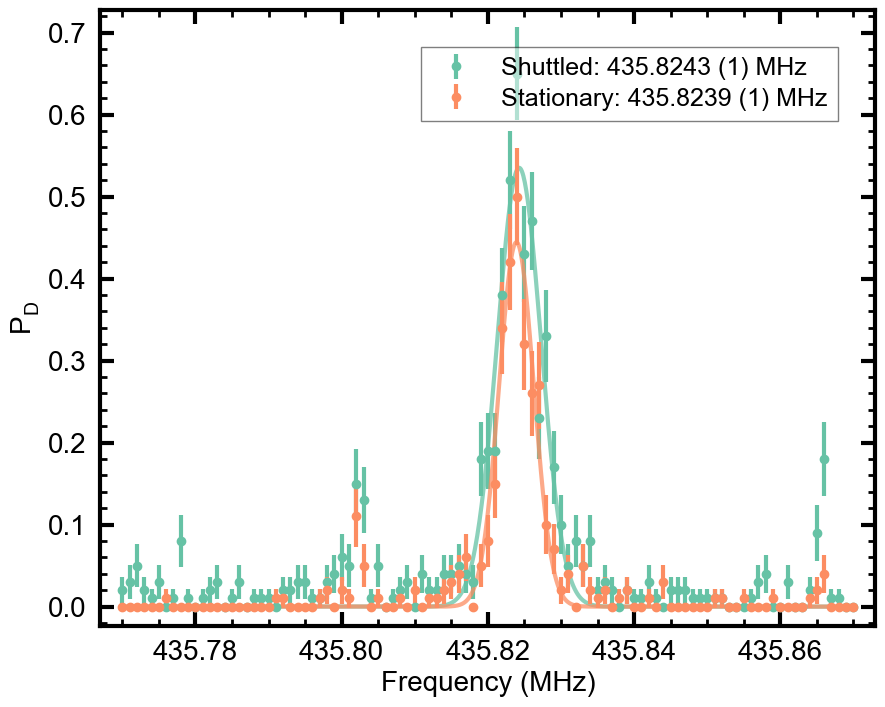

In [1439]:
f = plt.figure()
ax  = f.add_subplot(111)
j = 0

result, mod = Gaussian_fit(xdata[j],ydata[j],dydata[j])
dummyx = np.linspace(min(xdata[j]),max(xdata[j]),1000)
ax.errorbar(xdata[j],ydata[j],yerr=dydata[j],fmt='o',color=color_lst2[j],label='{}: {:.4f} ({:.0f}) MHz'.format(label[j],result.params['center'].value,
                                                                                                             result.params['center'].stderr*1e4))
ax.plot(dummyx,mod.eval(result.params,x=dummyx),color=color_lst2[(j)%8],alpha=0.75)

j = 1

result, mod = Gaussian_fit(xdata[j],ydata[j],dydata[j])
dummyx = np.linspace(min(xdata[j]),max(xdata[j]),1000)
ax.errorbar(xdata[j],ydata[j],yerr=dydata[j],fmt='o',color=color_lst2[j],label='{}: {:.4f} ({:.0f}) MHz'.format(label[j],result.params['center'].value,
                                                                                                             result.params['center'].stderr*1e4))
ax.plot(dummyx,mod.eval(result.params,x=dummyx),color=color_lst2[(j)%8],alpha=0.75)

ax.legend(loc='best')
ax.set_xlabel(r'Frequency (MHz)')
ax.set_ylabel(r'$\mathregular{P_D}$')
# f.savefig(os.path.join(saved_directory1,'freq_scan_with_shuttling_axial_sideband.png'),dpi=100,bbox_inches='tight',facecolor='white')

## Motional coherence

In [1672]:
def fit_osc_data(x,y,yerr=None):
    model = lmfit.models.ExpressionModel("ampl * sin((x)*freq + phi) + offset")
    model.set_param_hint("contrast", expr="ampl/offset")
    params = model.make_params(ampl=0.5*(max(y)-min(y)), freq=3, offset=0.5, phi=2*0.5)
    params["freq"].set(vary=False)
    params["ampl"].set(min=0,max=0.55)
    params["offset"].set(min=0,max=1,vary=False)
    params["phi"].set(min=-5,max=5)
    if yerr is None:
        result = model.fit(y,params,x=x)
    else:
        result = model.fit(y,params,x=x,weights=yerr)
    return result, model

In [1693]:
xdata = []
ydata = []
dydata = []
waiting = [0,0.001,0.2,1,2,5,10,20]
freq_scan = ['162037','163215','163949','162236','162414','162537','162815','163030']
# freq_scan = ['163949','164053']
# freq_scan = ['145655','145346'] # dither level 8
# label=['Shuttled', 'Stationary']

for j in range(len(freq_scan)):
    filename = os.path.join(directory+'\\%s'%subfolders[0],freq_scan[j])
    try:
        data = readdata(filename,camera=False)
    except:
        data = readdata(filename,camera=True)
    _xdata = np.array(data[:,2],dtype='float')
    _ydata = np.array(data[:,4],dtype='float')
    # if j==0:
    #     #_ydata = np.array(data[:,4],dtype='float')
    #     _ydata = np.zeros(len(_xdata))
    #     for k in range(len(_xdata)):
    #         out = np.histogram(data[k][6:],bins=[0,15,53,120],density=False)[0]
    #         _ydata[k] = out[1]/sum(out)
    # else:
    #     _ydata = np.zeros(len(_xdata))
    #     for k in range(len(_xdata)):
    #         out = np.histogram(data[k][6:],bins=[0,30,85,120],density=False)[0]
    #         _ydata[k] = out[1]/sum(out)
    num_trial = data[0][6:].shape[0]
    ion_1, dion_1 = binomial_mean_err(_ydata,num_trial)
    xdata.append(_xdata)
    ydata.append(ion_1)
    dydata.append(dion_1)

[[Model]]
    Model(power_exp)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 7
    # variables        = 3
    chi-square         = 0.00864844
    reduced chi-square = 0.00216211
    Akaike info crit   = -40.8740042
    Bayesian info crit = -41.0362738
[[Variables]]
    amp:    0.85029171 +/- 0.03336322 (3.92%) (init = 0.8808048)
    n:      0.65382619 +/- 0.09773025 (14.95%) (init = 1)
    decay:  2.65218129 +/- 0.48008693 (18.10%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(n, decay)   = 0.852
    C(amp, decay) = -0.540
    C(amp, n)     = -0.351


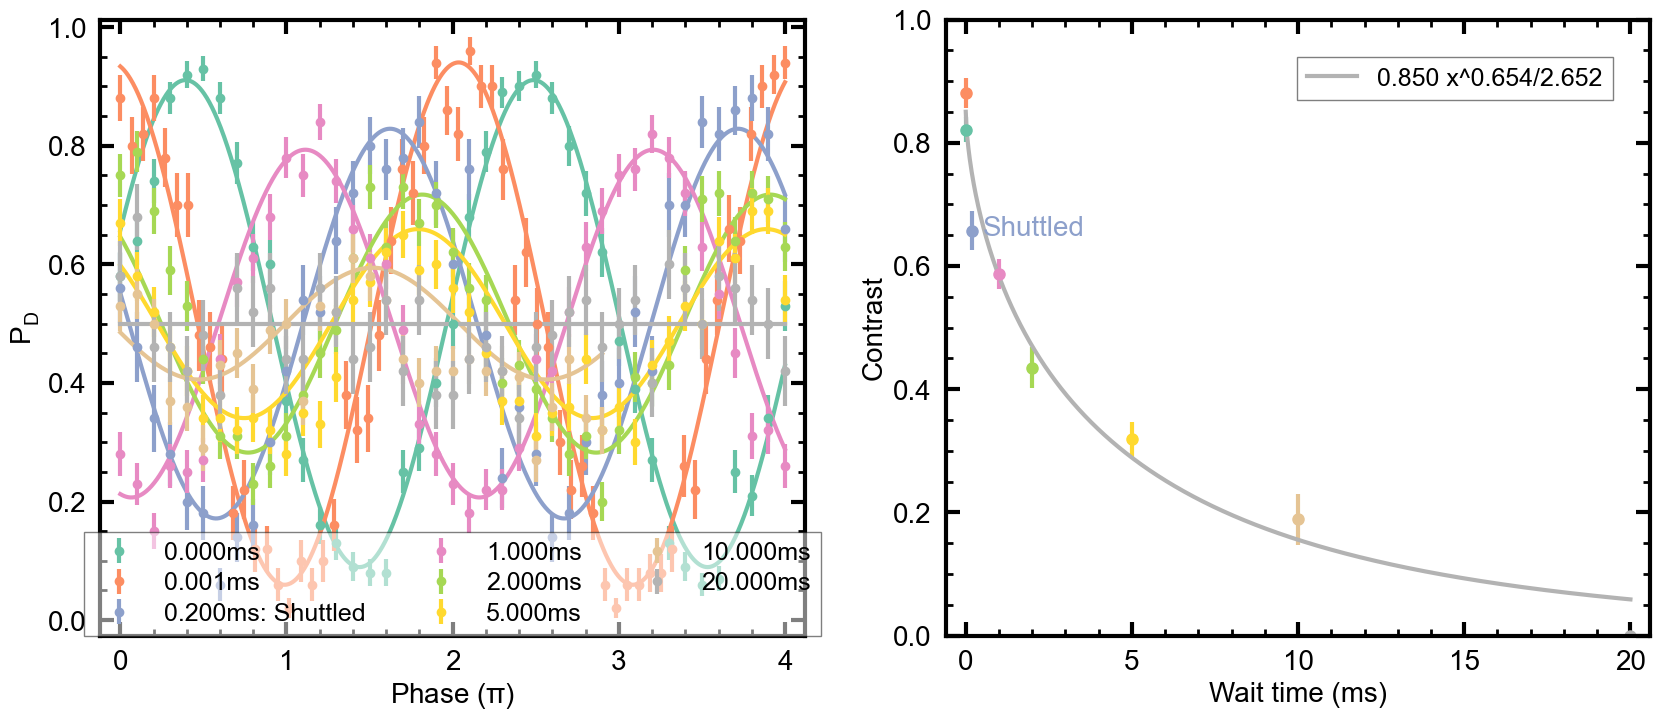

In [1707]:
contrast = []
dcontrast = []
f = plt.figure(figsize=(20,8))

ax = f.add_subplot(121)
for j in range(len(xdata)):
    if j!=2:
        label_string = '{:.3f}ms'.format(waiting[j])
    else:
        label_string = '{:.3f}ms: Shuttled'.format(waiting[j])
    ax.errorbar(xdata[j],ydata[j],yerr=dydata[j], fmt= 'o', color=color_lst2[j%8], label=label_string)
    res,mod = fit_osc_data(xdata[j],ydata[j],None)
    dummyx = np.linspace(min(xdata[j]),max(xdata[j]),1000)
    contrast.append(res.params['contrast'].value)
    try:
        if res.params['contrast'].stderr < 1 :
            dcontrast.append(res.params['contrast'].stderr)
        else:
            dcontrast.append(float('nan'))
    except:
        dcontrast.append(float('nan'))
    ax.plot(dummyx,mod.eval(res.params,x=dummyx),color=color_lst2[j%8])
ax.legend(loc='lower center',ncol=3, borderaxespad=0)
ax.set_xlabel('Phase ($\mathregular{\pi}$)')
ax.set_ylabel(r'$\mathregular{P_D}$')

ax1 = f.add_subplot(122)
ax1.set_xlabel('Wait time (ms)')
ax1.set_ylabel(r'Contrast')
for j in range(len(waiting)):
    ax1.errorbar(waiting[j], contrast[j], yerr=dcontrast[j], fmt='o', markersize=8, color=color_lst2[j])

def power_exp_fit(x,y,ax=None):
    def power_exp(x,amp,n,decay):
        return amp*np.exp(-x**n/decay)
    mod = Model(power_exp)
    params = mod.make_params(amp=max(y),n=1,decay=2)
    params['amp'].set(min=0)
    params['n'].set(min=0.1,max=3)
    params['decay'].set(min=0.1, max=100)
    result = mod.fit(y,params,x=x)
    
    if ax is not None:
        dummyx = np.linspace(min(x),max(x),1000)
        ax.plot(dummyx,mod.eval(result.params,x=dummyx),
                color=color_lst2[-1], label='{:.3f} x^{:.3f}/{:.3f}'.format(result.params['amp'].value,
                                                                          result.params['n'].value,
                                                                          result.params['decay'].value))
    print (result.fit_report())
    return result, mod 

valid = np.array(waiting) != 0.2
power_exp_fit(np.array(waiting)[valid], np.array(contrast)[valid],ax=ax1)
ax1.set_ylim(0,1)
ax1.text(0.5,0.65,'Shuttled',color=color_lst2[2])
ax1.legend(loc='best')
f.savefig(os.path.join(saved_directory1,'phase_scan_without_shuttling_motional_coherence_axialrsb.png'),dpi=100,bbox_inches='tight',facecolor='white')

Text(0, 0.5, '$\\mathregular{P_D}$')

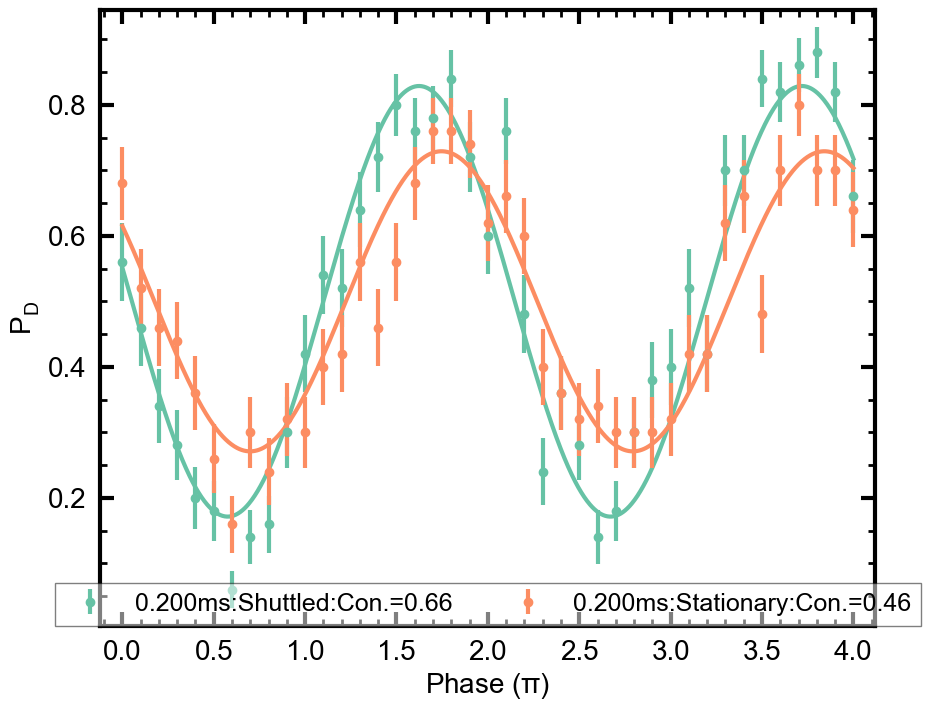

In [1691]:
contrast = []
dcontrast = []
_labels = ['Shuttled','Stationary']
f = plt.figure(figsize=(10,8))

ax = f.add_subplot(111)
for j in range(len(xdata)):

    res,mod = fit_osc_data(xdata[j],ydata[j],None)
    dummyx = np.linspace(min(xdata[j]),max(xdata[j]),1000)
    contrast.append(res.params['contrast'].value)
    ax.errorbar(xdata[j],ydata[j],yerr=dydata[j], fmt= 'o', color=color_lst2[j%8], label='{:.3f}ms:{}:Con.={:.2f}'.format(0.2,_labels[j],contrast[j]))
    try:
        if res.params['contrast'].stderr < 1 :
            dcontrast.append(res.params['contrast'].stderr)
        else:
            dcontrast.append(float('nan'))
    except:
        dcontrast.append(float('nan'))
    ax.plot(dummyx,mod.eval(res.params,x=dummyx),color=color_lst2[j%8])
ax.legend(loc='lower center',ncol=3, borderaxespad=0)
ax.set_xlabel('Phase ($\mathregular{\pi}$)')
ax.set_ylabel(r'$\mathregular{P_D}$')

## BSB and carrier flops

In [1759]:
bsb_filenames = ['133758','134001','133315','131928','132912','144733']
# bsb_filenames = ['163456','161541']

xdata = []
ydata = []
dydata = []
for j in range(len(bsb_filenames)):
    filename = os.path.join(directory+'\\%s'%subfolders[0],bsb_filenames[j])
    data = readdata(filename,camera=False)
    _xdata = np.array(data[:,2],dtype='float')
    _ydata = np.zeros(len(_xdata))
    if j==0:
        bins = [0,20,70,150]
        for k in range(len(_xdata)):
            out = np.histogram(data[k][6:],bins=bins,density=False)[0]
            _ydata[k] = out[0]/sum(out)
    elif j==5:
        bins = [0,25,90,180]
        for k in range(len(_xdata)):
            out = np.histogram(data[k][6:],bins=bins,density=False)[0]
            _ydata[k] = out[0]/sum(out)
    else:
        _ydata = np.array(data[:,4],dtype='float')
    num_trial = data[0][6:].shape[0]
    ion_1, dion_1 = binomial_mean_err(_ydata,num_trial)
    xdata.append(_xdata)
    ydata.append(ion_1)
    dydata.append(dion_1)

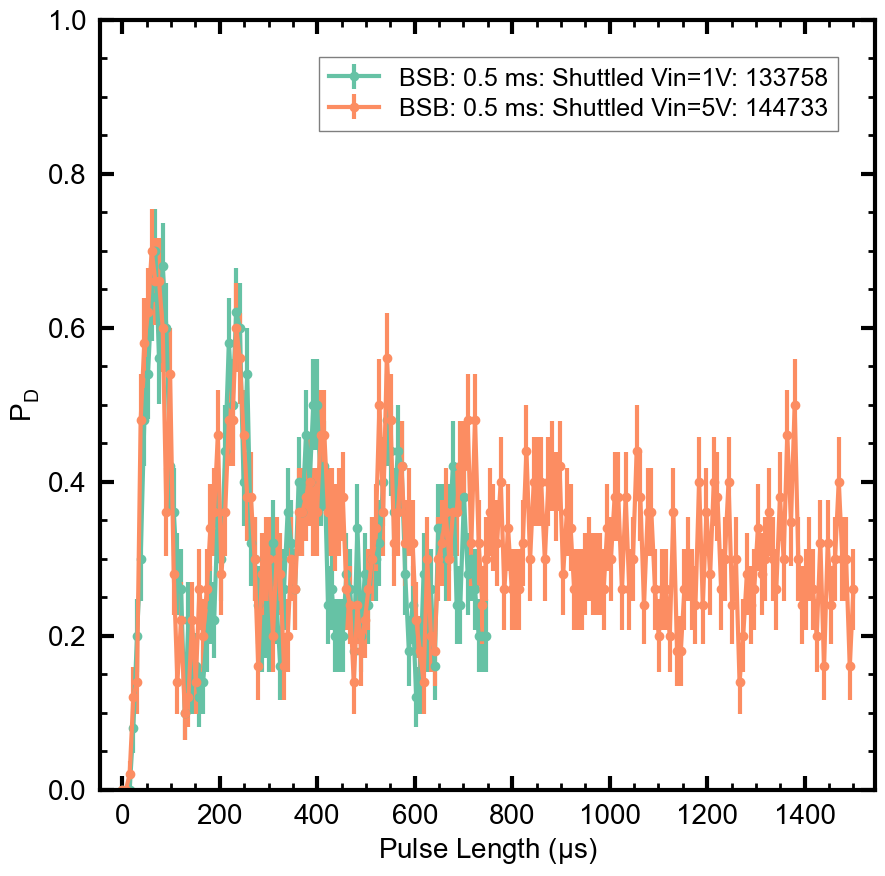

In [1761]:
f = plt.figure(figsize=(10,10))
ax0  =f.add_subplot(111)
j = 0
ax0.errorbar(xdata[j],ydata[j],yerr=dydata[j],fmt='o-',color=color_lst2[j],alpha=1,
           label = 'BSB: 0.5 ms: Shuttled Vin=1V: %s'%(bsb_filenames[j]))
# j = 1
# ax0.errorbar(xdata[j],ydata[j],yerr=dydata[j],fmt='o-',color=color_lst2[j],alpha=1,
#            label = 'BSB: 0.5 ms: Stationary: %s'%(bsb_filenames[j]))

# j = 3
# ax0.errorbar(xdata[j],ydata[j],yerr=dydata[j],fmt='o-',color=color_lst2[0],alpha=1,
#            label = 'Carrier: 0.5 ms: Shuttled: %s'%(bsb_filenames[j]))
# j = 4
# ax0.errorbar(xdata[j],ydata[j],yerr=dydata[j],fmt='o-',color=color_lst2[1],alpha=1,
#            label = 'Carrier: 0.5 ms: Stationary: %s'%(bsb_filenames[j]))

j = 5
ax0.errorbar(xdata[j],ydata[j],yerr=dydata[j],fmt='o-',color=color_lst2[1],alpha=1,
           label = 'BSB: 0.5 ms: Shuttled Vin=5V: %s'%(bsb_filenames[j]))

# j = 2
# ax0.errorbar(xdata[j],ydata[j],yerr=dydata[j],fmt='-',color=color_lst2[j],alpha=1,
#            label = 'Carrier: 0 ms: %s'%(bsb_filenames[j]))
ax0.set_ylim(0,1)
ax0.legend(loc='best')
ax0.set_xlabel(r'Pulse Length ($\mathregular{\mu s}$)')
ax0.set_ylabel(r'$\mathregular{P_D}$')
f.savefig(os.path.join(saved_directory1,'2ion_pulselength_scan_axial_bsb_shuttled.png'),dpi=100,bbox_inches='tight',facecolor='white')